# Process recount2 data
This notebook does the following:

1. Selects template experiment
2. Downloads subset of recount2 data, including the template experiment (subset of random experiments + 1 template experiment)
3. Train VAE on subset of recount2 data

In [1]:
%load_ext autoreload
%load_ext rpy2.ipython
%autoreload 2

import os
import sys
import pandas as pd
import numpy as np
import rpy2
import seaborn as sns
from sklearn import preprocessing
import pickle

from ponyo import utils, train_vae_modules
from generic_expression_patterns_modules import process, calc

np.random.seed(123)

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
Using TensorFlow backend.


In [2]:
# Read in config variables
base_dir = os.path.abspath(os.path.join(os.getcwd(),"../"))

config_file = os.path.abspath(os.path.join(base_dir,
                                           "configs",
                                           "config_test.tsv"))
params = utils.read_config(config_file)

### Select template experiment

We manually selected bioproject [SRP012656](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE37764), which contains primary non-small cell lung adenocarcinoma tumors and adjacent normal tissues of 6 never-smoker Korean female patients with 2 replicates each.

In [3]:
# Load params
local_dir = params["local_dir"]
dataset_name = params['dataset_name']
NN_architecture = params['NN_architecture']
project_id = params['project_id']
num_recount2_experiments = params['num_recount2_experiments_to_download']
template_data_file = os.path.join(local_dir, "recount2_template_data.tsv")
original_compendium_file = os.path.join(local_dir, "recount2_compendium_data.tsv")
normalized_data_file = os.path.join(local_dir, "normalized_recount2_compendium_data.tsv")
shared_genes_file = params['shared_genes_file']
scaler_file = params['scaler_transform_file']

In [4]:
# Check if analysis output directory exist otherwise create
if not os.path.exists(local_dir):
    os.makedirs(local_dir, exist_ok=True)

## Download data

In [5]:
%%R
suppressPackageStartupMessages(library('recount'))

In [6]:
%%R -i project_id -i num_recount2_experiments -i local_dir -i base_dir

source('../generic_expression_patterns_modules/download_recount2_data.R')

get_recount2_compendium(project_id, num_recount2_experiments, local_dir, base_dir)

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-09-01 17:36:18 downloading the metadata to /tmp/Rtmp70HgvC/metadata_clean_sra.Rdata

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'https://github.com/leekgroup/recount-website/blob/master/metadata/metadata_clean_sra.Rdata?raw=true'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Content type 'application/octet-stream'
  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2531337 bytes (2.4 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site

[1] "SRP012651"
Loading objects:
  rse_gene
[1] "SRP014574"
Loading objects:
  rse_gene
[1] "SRP000542"
Loading objects:
  rse_gene
[1] "SRP012656"
Loading objects:
  rse_gene


In [7]:
%%R -i project_id -i local_dir

source('../generic_expression_patterns_modules/download_recount2_data.R')

get_recount2_template_experiment(project_id, local_dir)

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-09-01 17:36:32 downloading file rse_gene.Rdata to SRP012656

  warnings.warn(x, RRuntimeWarning)


Loading objects:
  rse_gene


## Process data

In [8]:
# Get generic genes identified by Crow et. al.
DE_prior_file = "https://raw.githubusercontent.com/maggiecrow/DEprior/master/DE_Prior.txt"

DE_prior = pd.read_csv(DE_prior_file,
                       header=0,
                       sep="\t")

In [9]:
# Get list of published generic genes
published_generic_genes = list(DE_prior['Gene_Name'])

In [10]:
# Get list of our genes

# Read template data
template_data = pd.read_csv(
    template_data_file,
    header=0,
    sep='\t',
    index_col=0)

our_gene_ids = list(template_data.columns)

In [11]:
# File mapping ensembl ids to hgnc symbols
gene_id_file = os.path.join(
    "data",
    "metadata",
    "ensembl_hgnc_mapping.tsv")

In [12]:
%%R
suppressWarnings(library("biomaRt"))

In [13]:
%%R -i template_data_file -i gene_id_file

# Get mapping between ensembl gene ids (ours) to HGNC gene symbols (published)

source('../generic_expression_patterns_modules/process_names.R')

if (file.exists(gene_id_file) == FALSE){
    gene_id_mapping <- get_ensembl_symbol_mapping(template_data_file, gene_id_file)
}

In [14]:
# Read gene id mapping
gene_id_mapping = pd.read_csv(
        gene_id_file,
        header=0,
        sep='\t',
        index_col=0)

print(gene_id_mapping.shape)

(57165, 2)


In [15]:
# Get mapping between ensembl ids with and without version numbers
# Expressiond data uses ensembl gene ids with version number 
ensembl_gene_ids = pd.DataFrame(data={'ensembl_version': our_gene_ids,
                                      'ensembl_parsed': [gene_id.split('.')[0] for gene_id in our_gene_ids]})

print(ensembl_gene_ids.shape)

(58037, 2)


In [16]:
# Map ensembl ids with version number to gene_id_mapping_df
gene_id_mapping = pd.merge(gene_id_mapping, 
                           ensembl_gene_ids, 
                           left_on='ensembl_gene_id',
                           right_on='ensembl_parsed', 
                           how='outer')

print(gene_id_mapping.shape)
gene_id_mapping.set_index('ensembl_version', inplace=True)

(58041, 4)


In [17]:
# Replace ensembl ids with gene symbols
template_data = process.replace_ensembl_ids(template_data,
                                            gene_id_mapping)

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [18]:
# Get intersection of gene lists
our_gene_ids_hgnc = template_data.columns
shared_genes_hgnc = list(set(our_gene_ids_hgnc).intersection(published_generic_genes))
print(len(shared_genes_hgnc))

17784


In [19]:
# Remove subset of samples
smRNA_samples = ["SRR493961",
                 "SRR493962",
                 "SRR493963",
                 "SRR493964",
                 "SRR493965",
                 "SRR493966",
                 "SRR493967",
                 "SRR493968",
                 "SRR493969",
                 "SRR493970",
                 "SRR493971",
                 "SRR493972"]
template_data = template_data.drop(smRNA_samples)

In [20]:
# Drop genes
template_data = template_data[shared_genes_hgnc]

print(template_data.shape)

(24, 17787)


In [21]:
# Read data
print(template_data.shape)
assert(template_data.shape[0] == 24)
template_data.head()

(24, 17787)


,TAB2,PRSS12,POP5,ZFP69B,SYNPO,ITGB3,USE1,CHD2,PSORS1C2,ITPKB-IT1,...,PDCD2L,ZSCAN1,UACA,ATP7B,NIPBL,ACTR3,GTF2H1,MEX3D,MOBP,MUC13
SRR493937,2123,884,351,64,9696,774,433,7039,3,6,...,87,17,1718,265,2562,5141,903,852,33,160
SRR493938,2229,924,375,44,9711,762,452,7057,3,9,...,89,13,1742,250,2516,5161,902,952,28,159
SRR493939,2341,1455,653,127,4474,173,428,6019,13,2,...,663,7,1104,331,3191,4431,1268,1259,9,338
SRR493940,2357,1434,645,100,4530,184,443,6011,13,5,...,616,4,1020,317,3130,4380,1295,1246,10,295
SRR493941,2920,1240,443,20,13919,272,349,4286,12,2,...,133,8,4054,431,2366,4134,1071,1166,5,9


### Normalize compendium 

In [22]:
# Read data
original_compendium = pd.read_table(
    original_compendium_file,
    header=0,
    sep='\t',
    index_col=0)

print(original_compendium.shape)
original_compendium.head()

(92, 58037)


,ENSG00000000003.14,ENSG00000000005.5,ENSG00000000419.12,ENSG00000000457.13,ENSG00000000460.16,ENSG00000000938.12,ENSG00000000971.15,ENSG00000001036.13,ENSG00000001084.10,ENSG00000001167.14,...,ENSG00000283690.1,ENSG00000283691.1,ENSG00000283692.1,ENSG00000283693.1,ENSG00000283694.1,ENSG00000283695.1,ENSG00000283696.1,ENSG00000283697.1,ENSG00000283698.1,ENSG00000283699.1
SRR493816,525,0,884,428,449,37,532,2370,3393,727,...,0,2,0,0,0,0,13,17,0,0
SRR493817,348,0,790,342,364,57,23,1851,3986,614,...,0,1,0,0,0,0,12,24,0,0
SRR547975,335,0,1978,432,774,0,914,6974,425,2563,...,0,8,0,0,0,0,3,21,0,0
SRR547973,1111,0,1301,863,737,0,0,1912,3475,685,...,0,1,0,0,0,0,36,12,0,0
SRR547968,213,0,717,526,484,0,0,8267,2385,1829,...,0,0,0,0,0,0,24,34,0,0


In [23]:
# Replace ensembl ids with gene symbols
original_compendium = process.replace_ensembl_ids(original_compendium,
                                                gene_id_mapping)

In [24]:
# Drop genes
original_compendium = original_compendium[shared_genes_hgnc]

original_compendium.head()

,TAB2,PRSS12,POP5,ZFP69B,SYNPO,ITGB3,USE1,CHD2,PSORS1C2,ITPKB-IT1,...,PDCD2L,ZSCAN1,UACA,ATP7B,NIPBL,ACTR3,GTF2H1,MEX3D,MOBP,MUC13
SRR493816,2460,1446,714,44,4931,26,721,6772,9,0,...,625,3,610,540,981,3358,1152,877,2,0
SRR493817,2062,1228,427,24,6331,7,547,6173,10,0,...,552,1,400,432,875,2693,1090,1123,5,0
SRR547975,4244,6,659,3,5,25,578,5708,2,0,...,534,0,393,6807,2264,8241,2062,1234,0,16
SRR547973,3502,2048,329,166,48,0,484,7726,13,0,...,789,0,3405,1501,6490,6651,1630,420,0,16049
SRR547968,3071,23,487,26,39,0,193,5143,13,0,...,638,0,1470,3672,2621,5468,1888,668,0,1572


In [25]:
# 0-1 normalize per gene
scaler = preprocessing.MinMaxScaler()
original_data_scaled = scaler.fit_transform(original_compendium)
original_data_scaled_df = pd.DataFrame(original_data_scaled,
                                columns=original_compendium.columns,
                                index=original_compendium.index)

print(original_data_scaled_df.shape)
original_data_scaled_df.head()

(92, 17787)


,TAB2,PRSS12,POP5,ZFP69B,SYNPO,ITGB3,USE1,CHD2,PSORS1C2,ITPKB-IT1,...,PDCD2L,ZSCAN1,UACA,ATP7B,NIPBL,ACTR3,GTF2H1,MEX3D,MOBP,MUC13
SRR493816,0.309692,0.405671,0.548387,0.092437,0.307184,0.011102,0.713861,0.749443,0.004961,0.0,...,0.319530,0.107143,0.047203,0.079330,0.137981,0.237658,0.330840,0.498579,0.013072,0.000000
SRR493817,0.259465,0.344469,0.327957,0.050420,0.394487,0.002989,0.541584,0.682739,0.005513,0.0,...,0.282209,0.035714,0.030953,0.063464,0.122714,0.190283,0.313003,0.638431,0.032680,0.000000
SRR547975,0.534831,0.001404,0.506144,0.006303,0.000000,0.010675,0.572277,0.630958,0.001103,0.0,...,0.273006,0.000000,0.030411,1.000000,0.322771,0.585524,0.592635,0.701535,0.000000,0.000816
SRR547973,0.441191,0.574677,0.252688,0.348739,0.002681,0.000000,0.479208,0.855679,0.007166,0.0,...,0.403374,0.000000,0.263484,0.220508,0.931442,0.472252,0.468354,0.238772,0.000000,0.818910
SRR547968,0.386800,0.006176,0.374040,0.054622,0.002120,0.000000,0.191089,0.568040,0.007166,0.0,...,0.326176,0.000000,0.113751,0.539445,0.374190,0.387975,0.542578,0.379761,0.000000,0.080212


In [26]:
# Save data
template_data.to_csv(
    template_data_file, sep='\t')

original_compendium.to_csv(
    original_compendium_file, sep='\t')

original_data_scaled_df.to_csv(
    normalized_data_file, sep='\t')

# Save scaler transform
outfile = open(scaler_file,'wb')
pickle.dump(scaler,outfile)
outfile.close()

### Train VAE 
Performed exploratory analysis of compendium data [here](../explore_data/viz_recount2_compendium.ipynb) to help interpret loss curve.

In [27]:
# Setup directories
# Create VAE directories
output_dirs = [os.path.join(base_dir, dataset_name, "models"),
               os.path.join(base_dir, dataset_name, "logs")]

# Check if analysis output directory exist otherwise create
for each_dir in output_dirs:
    if os.path.exists(each_dir) == False:
        print('creating new directory: {}'.format(each_dir))
        os.makedirs(each_dir, exist_ok=True)

# Check if NN architecture directory exist otherwise create
for each_dir in output_dirs:
    new_dir = os.path.join(each_dir, NN_architecture)
    if os.path.exists(new_dir) == False:
        print('creating new directory: {}'.format(new_dir))
        os.makedirs(new_dir, exist_ok=True)

input dataset contains 92 samples and 17787 genes
Instructions for updating:
Colocations handled automatically by placer.
tracking <tf.Variable 'Variable:0' shape=() dtype=float32> beta
Instructions for updating:
Use tf.cast instead.


/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/keras/engine/training_utils.py:819: UserWarning: Output custom_variational_layer_1 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to custom_variational_layer_1.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 83 samples, validate on 9 samples
Epoch 1/5
83/83 [==============================] - 21s 257ms/step - loss: 9232.5713 - val_loss: 48419.2474
Epoch 2/5
83/83 [==============================] - 21s 252ms/step - loss: 8227.6902 - val_loss: 14800.4535
Epoch 3/5
83/83 [==============================] - 21s 253ms/step - loss: 7932.4739 - val_loss: 10475.9287
Epoch 4/5
83/83 [==============================] - 21s 252ms/step - loss: 7885.2603 - val_loss: 11746.8634
Epoch 5/5
83/83 [==============================] - 21s 252ms/step - loss: 7910.9757 - val_loss: 9390.4757


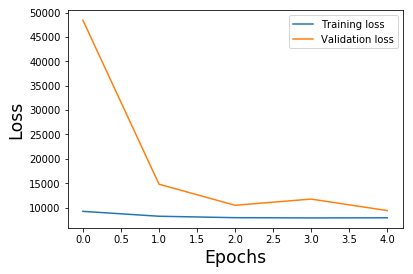

In [28]:
# Train VAE on new compendium data
train_vae_modules.train_vae(config_file,
                            normalized_data_file)

In [30]:
# Test reproducibility
template_path = "data/test_vae_logs.tsv"
output_path = "logs/NN_2500_30/tybalt_2layer_30latent_stats.tsv"
assert np.all(np.isclose(
    pd.read_csv(output_path, sep="\t").values,
    pd.read_csv(template_path, sep="\t").values
    ))